## Logistic Regression

The Linear Regression model we've seen does not work well on classification problems, where we need to define an output out of a limited number of possibilities. 

A typical case of classification is a prediction of a binary outcome (for example, True or False). The picture below shows why linear regression (left image) won't work well for binary outcomes. It also shows an alternative function that works much better, the logistic regression (or sigmoid) function:

$$ g(x) = \frac{1}{1+e^-x} $$

As we can see on the right image below, this function is a much better fit for binary outputs as its value ranges between 0 and 1 regardless of the value of the input:

Image source: https://www.kaggle.com/code/meetnagadia/logistic-regression-on-heart-data


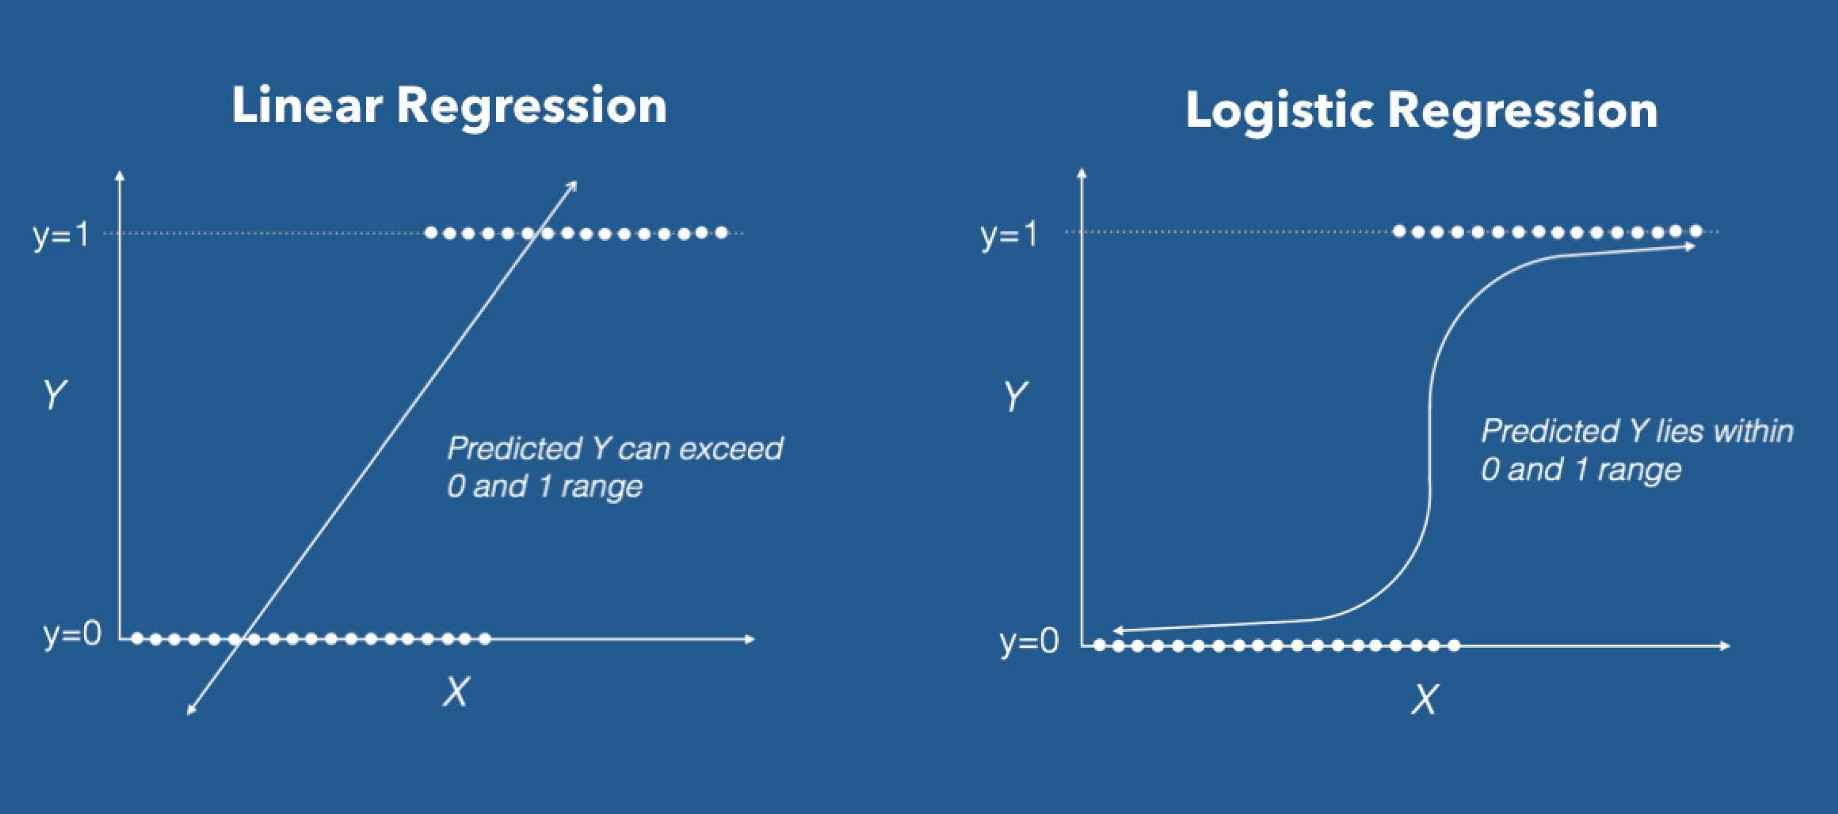

In [3]:
from IPython import display
print(f"Image source: https://www.kaggle.com/code/meetnagadia/logistic-regression-on-heart-data")
display.Image("images/Logistic_regression.jpeg")

To use this function in the context of our regression model, we redefine the prediction function as:

$$ f_{W,b}(X) = g(W•X + b) = \frac{1}{1+e^{-(W•X+b)}} $$

Notice that we are basically using a bayesian model where:

$$ f_{W,b}(X) = P(y=1|X,W,b) $$

That is, the result of the predictive function gives us the probability that the output is "1" given that we know the values of input X and parameters W and b.

A "problem" with this is that, when we have several samples, our cost function won't be a sum but a product, since aggregated probabilities are multiplied, not added. One ingenious way to work around this is to take the log() of the cost function instead of the function itself. Since we know that the optimal value won't be modified if we use the log(), this will not affect our desired outcome.

So now we have a **logistic loss function** for sample ' *i* ' as:

$ f_{W,b}(X^{(i)}), Y^{(i)} = -log(f_{W,b}(X^{(i)})), \quad if \quad y^{(i)}=1 $ and\
$ f_{W,b}(X^{(i)}), Y^{(i)} = -log(1-f_{W,b}(X^{(i)})), \quad if \quad y^{(i)}=0 $

With this, we can see that the **Cost Function** is now:

$ J(W,b) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)}log(f_{(W,b)}(X^{(i)}) + (1-y^{(i)})log(1-f_{(W,b)}(X^{(i)}))] $

And to define the direction we need to use to minimise this function with respect to parameters W and b, just like on the linear regression, we have:

$ w_{j} = w_{j} - \theta \frac{\partial{J_{i}(W,b)}}{\partial{w_{j}}} $\
$ b = b - \theta \frac{\partial{J(W,b)}}{\partial{b}} $

working out the partial derivatives, we have:

$ \frac{\partial{J_{j}(W,b)}}{\partial {w}} = \frac{\text{1}}{\text{m}} * \sum_{i=1}^{m} (f_{W,b}(X^{(i)}) - {y}^{(i)})•x_{j}^{(i)} $

$ \frac{\partial{J(W,b)}}{\partial {b}} = \frac{\text{1}}{\text{m}} * \sum_{i=1}^{m} (f_{W,b}(X^{(i)}) - y^{(i)}) $

First, let's load the required general libraries and load the data. We will use a heart_disease from Kaggle available at "https://www.kaggle.com/code/meetnagadia/logistic-regression-on-heart-data/input"

In [2]:
import numpy as np
import random
import copy 
import math
import time
import pandas as pd 

df = pd.read_csv('data/heart_data.csv')
print(f"shape of the data: {df.shape}")
df.head()


shape of the data: (304, 15)


,id,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63.0,1.0,typical,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,fixed,No
1,2,67.0,1.0,asymptomatic,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,normal,Yes
2,3,67.0,1.0,asymptomatic,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,reversable,Yes
3,4,37.0,1.0,nonanginal,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,normal,No
4,5,41.0,0.0,nontypical,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,normal,No


Notice that we need to binary encode categorical features like "ChestPain" and "Thal". We also need to redefine AHD (the output or dependent variable) from "No/Yes" to "0/1". It is useful to normalise the data as well, especially when the scales are different between the variables (as is the case here).

In [3]:
# First, let's define the input and output matrix and vector:
Y = df['AHD']
X = df.drop('AHD', axis=1)

# First, we'll save a copy of the original data
X_orig = copy.deepcopy(X)

# redefine input by normalising the features
X['RestBP'] = (X['RestBP'] - np.min(X['RestBP']) ) / (np.max(X['RestBP']) - np.min(X['RestBP']))
X['Chol'] = (X['Chol'] - np.min(X['Chol']) ) / (np.max(X['Chol']) - np.min(X['Chol']))
X['MaxHR'] = (X['MaxHR'] - np.min(X['MaxHR']) ) / (np.max(X['MaxHR']) - np.min(X['MaxHR']))
X['Age'] = (X['Age'] - np.min(X['Age']) ) / (np.max(X['Age']) - np.min(X['Age']))

# Binary code categorical features
X['ChestPain_typical'] = [1 if i == 'typical' else 0 for i in X['ChestPain']]
X['ChestPain_asymptomatic'] = [1 if i == 'asymptomatic' else 0 for i in X['ChestPain']]
X['ChestPain_nonanginal'] = [1 if i == 'nonanginal' else 0 for i in X['ChestPain']]
X['ChestPain_nontypical'] = [1 if i == 'nontypical' else 0 for i in X['ChestPain']]

X['Thal_fixed'] = [1 if i == 'fixed' else 0 for i in X['Thal']]
X['Thal_normal'] = [1 if i == 'normal' else 0 for i in X['Thal']]
X['Thal_reversable'] = [1 if i == 'reversable' else 0 for i in X['Thal']]

# Now, let's drop the categorical data before replacing NaN
X = X.drop('ChestPain', axis=1)
X = X.drop('Thal', axis=1)
X = X.drop('id', axis=1)

# Now, we can replace the NaN values with the averages of each column. Notice that we have to 
# evaluate with domain experts to define what to do with missing or outlier data
column_means = X.mean()
X = X.fillna(column_means)

X = np.array(X)


In [4]:
# Now, let's format the output variable
Y = [1 if i == 'Yes' else 0 for i in df['AHD']]
Y = np.array(Y)

In [5]:
print(f"X.shape: {X.shape}")
print(f"Y.shape: {Y.shape}")

X.shape: (304, 18)
Y.shape: (304,)


Now, let's separate the data set into training and test:

In [6]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

We will define the sigmoid function to simplify the code later on. Notice that we define the exp with the numpy version of the function instead of the math version. We do this because the numpy version supports arrays while the math function only works with float values.

In [7]:
# returns the sigmoid of vector or scalar z
def sigmoid(z):
    g = 1/(1 + np.exp(-z))
    return g

Now, let's define the cost function:

In [8]:
# Calculates the cost function for some given parameters
def cost_func(X,Y,W,b):
    
    m, _ = X.shape # remember that input X is in matrix form (m,n), with m=num samples, n=num features
    
    total_cost = 0
    sig = 0

    # calculate the sum going through the samples
    for i in range(m):
        sig = sigmoid(np.dot(W.T, X[i]) + b)
        total_cost += Y[i]*np.log(sig) + (1 - Y[i])*np.log(1-sig)

    return -total_cost

The function to calculate the partial derivatives:

In [10]:
# Calculates the partial derivatives
def gradient(X,Y,W,b):
    
    m,n = X.shape # sample size
    
    # initialises values to zero
    dj_dw = np.zeros(n)
    dj_db = 0

    # Validates shapes of matrices
    try:
        assert len(W) == len(X[1]), "Check shape of W and X"
    except AssertionError as msg:
        print(msg)

    # calculates derivatives
    sig = 0
    for i in range(m): # goes through the samples
        sig = sigmoid(np.dot(W.T, X[i]) + b)
        dj_db += sig - Y[i]

        for j in range(n): # goes though the features
            dj_dw += sig * X[i][j]

    # calculate averages
    dj_db = dj_db / m
    dj_dw = dj_dw / m

    return dj_dw, dj_db

A function to fit the data and find the optimal parameters:

In [11]:
def fit_log_reg(X,Y, W_ini, b_ini, cost_func = cost_func, theta = 0.00001, num_iter = 1000):
    # set initial values
    J_values = []
    w = copy.deepcopy(W_ini)
    b = b_ini

    # iterations
    for i in range(num_iter):

        # calculate gradients according to eqs (4) and (5)
        dj_dw, dj_db = gradient(X,Y,w,b)
        #print(f"dj_dw: {dj_dw}")

        # updating parameter values according to eqs (2) and (3)
        w = w - theta * dj_dw
        b = b - theta * dj_db

        # store cost function values
        J_values.append(cost_func(X,Y,w,b))

        # print out values to evaluate convergence
        if i < 100000: # to limit the 
        
            if i% math.ceil(num_iter/10) == 0:
                print(f"Iteration {i:4d}: Cost value {J_values[-1]:6.2f} ")
                #print(f"w: {w} b:{b}")

    return w, b, J_values

The prediction equation, once we have the optimal parameters is:

In [12]:
def prediction(X,W,b):
    
    # initialise output value
    y_hat = np.zeros(X.shape[0])

    m = X.shape[1] # number of samples in the set

    for i in range(m):
        y_hat[i] = sigmoid(np.dot(W.T, X[i]) + b)

    y_hat_out = [1 if i > 0.5 else 0 for i in y_hat]

    return y_hat_out

Now, let's calculate the model:

In [19]:
# We define the learning rate theta and initialise the parameters
theta = 0.00001
W = np.random.rand(X.shape[1])
b = 0

time_ini_self_coding = time.time()
w_opt, b_opt, J_values = fit_log_reg(X_train, y_train, W_ini=W, b_ini=b, theta = theta, num_iter=6000)
time_end_self_coding = time.time()

Iteration    0: Cost value 436.66 
Iteration  600: Cost value 391.68 
Iteration 1200: Cost value 347.93 
Iteration 1800: Cost value 305.82 
Iteration 2400: Cost value 265.91 
Iteration 3000: Cost value 228.82 
Iteration 3600: Cost value 195.30 
Iteration 4200: Cost value 166.08 
Iteration 4800: Cost value 141.83 
Iteration 5400: Cost value 123.00 


Now, let's generate the predictions:

In [20]:
y_hat_test = prediction(X_test, w_opt, b_opt)
y_hat_train = prediction(X_train, w_opt, b_opt)

In [21]:
# Analysis of predictions for the test set
y_hat_test = np.array(y_hat_test)
y_hat_train = np.array(y_hat_train)

# Evaluate the test results
true_pos = sum((y_test == 1) & (y_hat_test == 1))
false_pos = sum((y_test == 0) & (y_hat_test == 1))
false_neg = sum((y_test == 1) & (y_hat_test == 0))

prec = true_pos / (true_pos + false_pos)
rec = true_pos / (true_pos + false_neg)

# analysis of performance
print(f"Precision: {prec:.2f}\nRecall: {rec:.2f}")
print(f"Accuracy in the test set: {sum((y_test==y_hat_test))/len(y_test):.2f}")


Precision: 0.82
Recall: 0.24
Accuracy in the test set: 0.66


We see that the model is very good at predicing positive cases, but the Recall evidentiates that it is predicting too many false_negatives. Further analysis should be made with the parameters or maybe evaluate other models that can better predict more complex data.

Let's try a more industry-standard and efficient implementation of the algorithm: sklearn

In [22]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_hat_test_sklearn = clf.predict(X_test)

In [24]:
# Evaluate the test results
true_pos = sum((y_test == 1) & (y_hat_test_sklearn == 1))
false_pos = sum((y_test == 0) & (y_hat_test_sklearn == 1))
false_neg = sum((y_test == 1) & (y_hat_test_sklearn == 0))

prec = true_pos / (true_pos + false_pos)
rec = true_pos / (true_pos + false_neg)

# analysis of performance
print(f"Precision: {prec:.2f}\nRecall: {rec:.2f}")
print(f"Accuracy in the test set: {sum((y_test==y_hat_test_sklearn))/len(y_test):.2f}")

Precision: 0.82
Recall: 0.71
Accuracy in the test set: 0.82


We find a similar Precision, but a much better Recall and Accuracy.